# Table of Contents

0. Introduction
   
1. Load the dataset  
   1.1. categorical value를 encoding하기  
   1.2. Convert to Sequential Dataset  

2. LSTM; Long Short Term Memory  
   2.1. 평가 및 문제사항

# 0. Introduction

**Dataset**  
* [abalone(전복)](https://archive.ics.uci.edu/dataset/1/abalone) | [Download csv file](https://github.com/MyungKyuYi/AI-class/blob/main/abalone.csv)

**Environment**
* macOS `x86`cpu

**Framework**  
* TensorFlow: Version `2.10.0`

**Dependencies**  
* Python: Version `3.9.19`
* Numpy: Version `1.24.3`
* Pandas: Version `2.2.2`
* Matplotlib: Version `3.9.2`
* scikit-learn: Version `1.2.2`

**Purpose**  
* abalone dataset에 대해서 LSTM을 사용한 Regression을 수행한다.

**Abstraction**  
Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.  
From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).

# 1. Load the dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load the dataset

# csv file의 0번 column을 index로 지정
# dataframe 상에서는 보이지만, 실제로 features에 포함되지는 않음
df = pd.read_csv('./datasets/abalone.csv', index_col=0)
df

# 일단 즉시 눈에 보이는 것과 그에 대한 예상 행동은 다음과 같다.
# 1. 'Sex'가 Categorical value를 가진다.
# -> values를 확인하고, integer로 mapping한다.
## 아래 2번은 지금은 regression이니까 무시함.
# 2. 'Rings'가 Categorical value로 의심된다.
# -> 일단 regression을 수행해야 하므로 values를 확인한다.

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
id,,,,,,,,,
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9


> **index는 넣어도 그만, 안 넣어도 그만이다. 그런데 넣지 말아야 하는 이유는?**  
curse of dimensionality를 방지하기 위해서이다.  
MLDL의 목적은 "최소한의 데이터(또는 학습)로, 최대한의 성능을"이다.  
따라서 성능에 별 다른 도움을 주지 않을 것으로 예상되는 `id`를 굳이 학습에 사용할 필요는 없다.  
괜히 features의 수 즉, dimension의 증가만 야기하기 때문이다.

In [3]:
print(f"df.shape: {df.shape}")
print(f"df.columns: {df.columns}")

df.shape: (4177, 9)
df.columns: Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')


In [4]:
# features description
'''
Sex              | M, F, and I(infant)          | 수컷, 암컷, 미성숙함(구분 불가)
Length           | Longest shell measurement    | 껍질의 장축 길이
Diameter         | perpendicular to length      | 껍질의 단축 길이
Height           | with meat in shell           | 높이(껍질 외에도 살 부분을 포함)
Whole_weight     | whole abalone                | 껍질 + 살 무게
Shucked_weight   | weight of meat               | 껍질을 제외한 살 무게
Viscera_weight   | gut weight(after bleeding)   | 피를 뺀 후의 내장 무게
Shell_weight     | after being dried            | 건조 후의 껍질 무게
Rings            | +1.5 gives the age in years  | 껍질의 ring의 수, 1.5를 곱하면 실제 나이
'''

'\nSex              | M, F, and I(infant)          | 수컷, 암컷, 미성숙함(구분 불가)\nLength           | Longest shell measurement    | 껍질의 장축 길이\nDiameter         | perpendicular to length      | 껍질의 단축 길이\nHeight           | with meat in shell           | 높이(껍질 외에도 살 부분을 포함)\nWhole_weight     | whole abalone                | 껍질 + 살 무게\nShucked_weight   | weight of meat               | 껍질을 제외한 살 무게\nViscera_weight   | gut weight(after bleeding)   | 피를 뺀 후의 내장 무게\nShell_weight     | after being dried            | 건조 후의 껍질 무게\nRings            | +1.5 gives the age in years  | 껍질의 ring의 수, 1.5를 곱하면 실제 나이\n'

In [5]:
# missing value를 확인하는 방법 두 가지
# sol1. DataFrame.info()는 Non-Null Count & Dtype을 리턴함
print(df.info())
print("\n\n")
# sol2. DataFrame.isnull().sum()은 Null Count를 리턴함 -> Null 확인에는 더 직관적임
print(df.isnull().sum())
print("\n\n")

# 또한 이를 응용하여 dataset 전체에 null이 존재하는지 여부를 출력하는 if statement를 작성 가능
if (df.isnull().sum().sum() == 0): print("There are no missing values.")
print("\n\n")

# 또한 이를 응용하여 null이 존재한다면 자동으로 처리하는 if statement를 작성 가능
# 해당 예제에서는 missing value를 '제거'하도록 작성함. 이외에도 missing value 처리 방법은 다양함
if (df.isnull().sum().sum() == 0):
    print("There are no missing values.")
else:
    print("missing values가 존재하여 처리합니다. \n처리 방법: 삭제")
    df = df.dropna()

# 해당 dataset에는 missing value가 존재하지 않기 때문에 별도로 작동하지는 않음

<class 'pandas.core.frame.DataFrame'>
Index: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 326.3+ KB
None



Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64



There are no missing values.



There are no missing values.


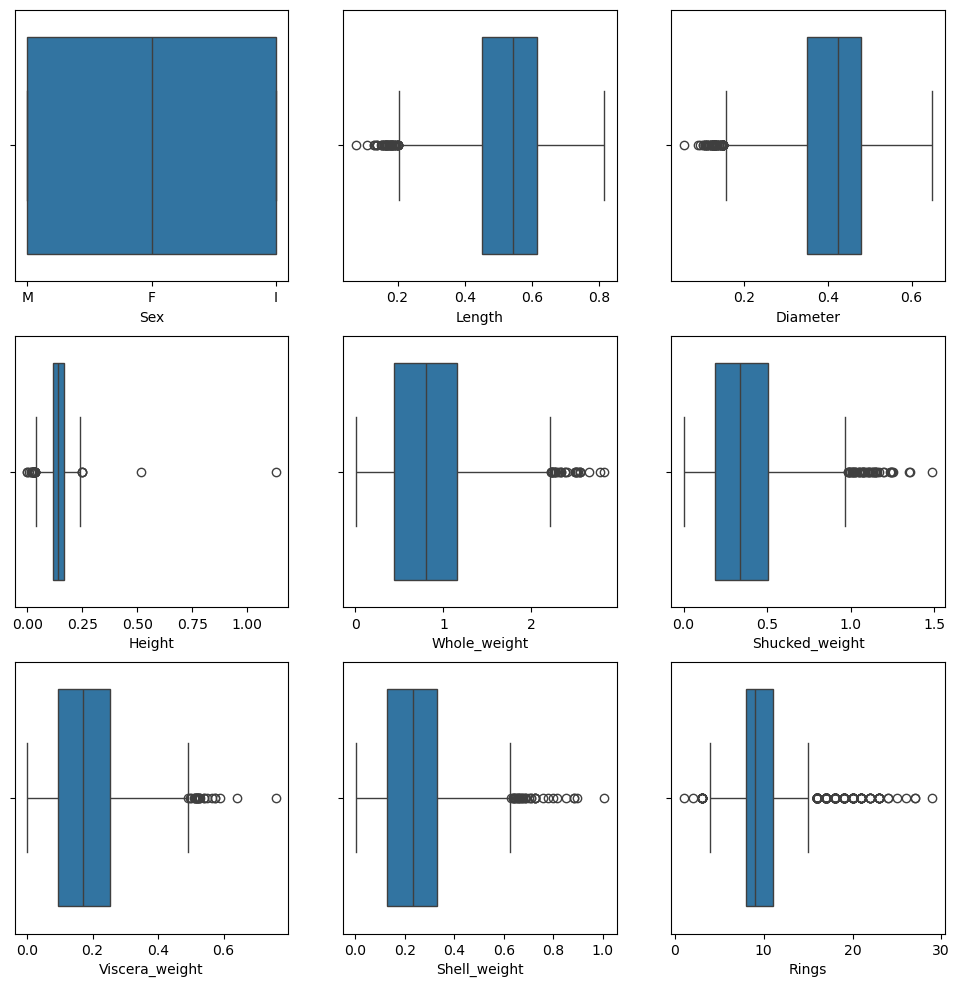

In [6]:
# 각 column에 대한 boxplot plotting
columns = df.columns
figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 3
idx = 1

for column in columns:
    # 이 아래로는 각 subplot에 개별로 적용됨
    figure.add_subplot(rows, cols, idx) # rows by cols의 idx번 째 
    sns.boxplot(data=df, x=column)
    idx += 1

plt.show()

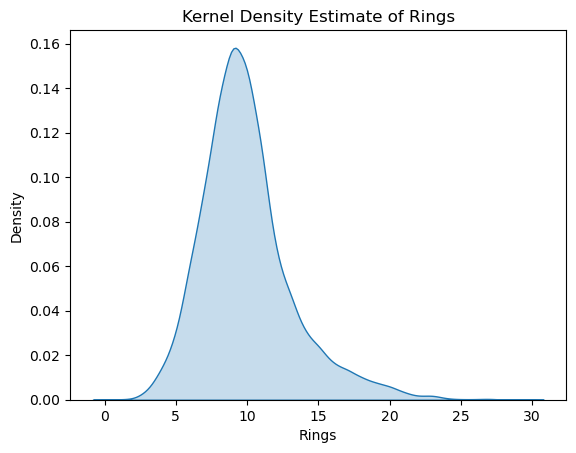

In [7]:
sns.kdeplot(df['Rings'], fill=True)
plt.title('Kernel Density Estimate of Rings')
plt.xlabel('Rings')
plt.ylabel('Density')
plt.show()

## 1.1. categorical value를 encoding하기

In [8]:
# categorical value를 가지는 column 확인
np.unique(df['Sex'])

array(['F', 'I', 'M'], dtype=object)

In [9]:
# 위에서 'Sex'에 null이 없음을 확인했으니 mapping하여 encoding한다.
sex_mapping = {'M': 0, 'F': 1, 'I': 2}
df['Sex'] = df['Sex'].map(sex_mapping)
df

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
id,,,,,,,,,
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,1,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,0,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,0,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9


In [10]:
# DataFrame.describe()는 dataset에 대한 statistical values를 제공함
df.describe()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.955470,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.827815,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.000000,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,1.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,2.000000,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,2.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


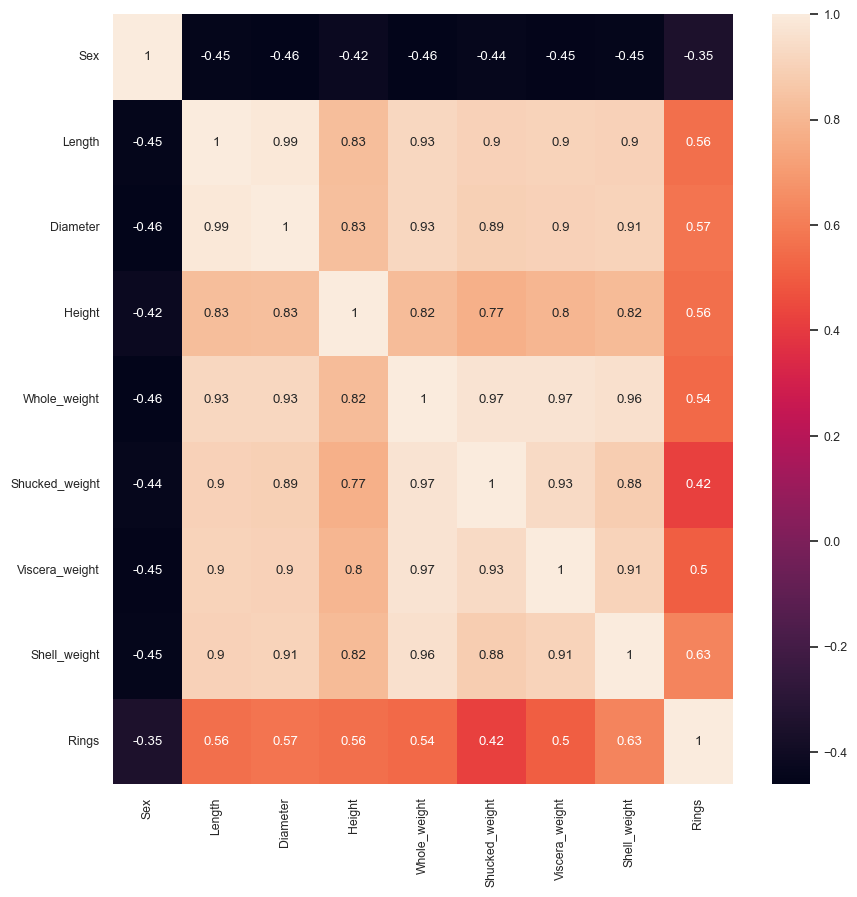

In [11]:
# Check the correlations(1) by heatmap
# If corr >= 0.3, positive-correlated and if corr >= 0.7, high correlated
# If corr <= -0.3, negative-correlated and if corr <= -0.7, high correlated
df_corr = df.corr()

plt.figure(figsize=(10, 10))
sns.set(font_scale=0.8)
sns.heatmap(data=df_corr, annot=True)
plt.show()

In [12]:
# # # Check the correlations(2) by pairplot
#   # 'Rings'에 대해 구분
# sns.pairplot(data=df,
#              vars=['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
#                    'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings'],
#              hue='Rings')
# plt.show()

In [13]:
# # # Check the correlations(2) by pairplot
#   # 'Sex'에 대해 구분
# sns.pairplot(data=df,
#              vars=['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
#                    'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings'],
#              hue='Sex')
# plt.show()

## 1.2. Convert to Sequential Dataset

In [14]:
# X, y 분리
X = df.drop('Rings', axis=1).to_numpy()
y = df['Rings'].to_numpy()

print(f"X.head(): \n{X[:5]} \n")
print(f"y.head(): \n{y[:5]}")

X.head(): 
[[0.     0.455  0.365  0.095  0.514  0.2245 0.101  0.15  ]
 [0.     0.35   0.265  0.09   0.2255 0.0995 0.0485 0.07  ]
 [1.     0.53   0.42   0.135  0.677  0.2565 0.1415 0.21  ]
 [0.     0.44   0.365  0.125  0.516  0.2155 0.114  0.155 ]
 [2.     0.33   0.255  0.08   0.205  0.0895 0.0395 0.055 ]] 

y.head(): 
[15  7  9 10  7]


In [15]:
# train, test 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=42)

print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (3132, 8)
X_test.shape: (1045, 8)
y_train.shape: (3132,)
y_test.shape: (1045,)


In [16]:
# scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
# X와 y를 하나로 합친 dataset 만들기
# 합치기 위해서는 y도 2dim으로 변경해줘야됨 by reshape()
train_set = np.c_[X_train, y_train.reshape(-1, 1)]
test_set = np.c_[X_test, y_test.reshape(-1, 1)]

print(f"train_set.head(): \n{train_set[:5]}")

train_set.head(): 
[[ 6.07407457e-02  7.49290761e-01  4.64225837e-01 -1.18869233e-01
   4.57446573e-01  4.99097874e-01  7.43972878e-01  2.41134902e-01
   9.00000000e+00]
 [ 6.07407457e-02 -9.02537114e-02 -1.44654423e-01 -1.64680298e-03
  -3.01654922e-01 -3.64269333e-01 -5.14039773e-01 -1.45837777e-01
   1.20000000e+01]
 [-1.15097910e+00  1.12708577e+00  1.22532616e+00  8.18910208e-01
   1.52385189e+00  1.69211438e+00  1.54452638e+00  1.17990196e+00
   1.00000000e+01]
 [-1.15097910e+00 -5.93980395e-01 -4.49094554e-01 -1.05664867e+00
  -6.51696363e-01 -6.17673214e-01 -7.38194754e-01 -6.47469029e-01
   1.50000000e+01]
 [-1.15097910e+00 -2.58162606e-01 -9.39144017e-02  3.50020487e-01
  -5.23521522e-02 -5.72822969e-01 -6.05531602e-01  7.85763118e-01
   6.00000000e+00]]


In [18]:
# Sequential dataset 만들기(1)
def split_sequences(data, n_steps):
    """
    비연속 데이터셋을 일정한 길이의 연속적인 시퀀스로 변환하는 함수.
    
    Args:
    data: 원본 데이터 (리스트 또는 배열)
    n_steps: 시퀀스의 길이 (정수)
    
    Returns:
    X: 입력 시퀀스
    y: 해당 시퀀스에 대한 다음 값 (타겟 값)
    """
    X, y = [], []
    
    for i in range(len(data)):
        # 데이터의 끝에서 시퀀스 길이 만큼 남은 경우 종료
        end_idx = i + n_steps
        if end_idx > len(data) - 1: break
        
        # 입력 시퀀스와 출력 값(목표값)을 분리
        seq_x, seq_y = data[i:end_idx, :-1], data[end_idx, -1]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [19]:
# Sequential dataset 만들기(2)
n_steps = 3 # 전복 3마리를 한 개의 set으로 묶기
X_train_seq, y_train_seq = split_sequences(train_set,
                                           n_steps)

X_test_seq, y_test_seq = split_sequences(test_set,
                                         n_steps)

print(f"X_train_seq.shape: {X_train_seq.shape}", end=" ")
print(f"y_train_seq.shape: {y_train_seq.shape}")
print(f"X_test_seq.shape: {X_test_seq.shape}", end=" ")
print(f"y_test_seq.shape: {y_test_seq.shape}")

X_train_seq.shape: (3129, 3, 8) y_train_seq.shape: (3129,)
X_test_seq.shape: (1042, 3, 8) y_test_seq.shape: (1042,)


In [20]:
n_steps = X_train_seq.shape[1]
features = X_train_seq.shape[2]

# 2. CNN; Convolutional Neural Network

In [21]:
import tensorflow as tf
import tensorflow.keras as keras

2024-09-25 23:09:38.226402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# Create the model
model = keras.models.Sequential()

# Add the layers to model
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LSTM(units=128,
                            # activation='relu',
                            input_shape=(n_steps, features),
                            name='lstm1'))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=128,
                             activation='relu',
                             name='dense1'))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=1,
                             name='output'))

model.summary()

2024-09-25 23:09:40.420714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm1 (LSTM)                (None, 128)               70144     
                                                                 
 dense1 (Dense)              (None, 128)               16512     
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 86,785
Trainable params: 86,785
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

In [24]:
epochs = 50
history = model.fit(X_train_seq, y_train_seq,
                    batch_size=32,
                    validation_split=0.1,
                    shuffle=True,
                    verbose=2,
                    epochs=epochs)

Epoch 1/50
88/88 - 2s - loss: 50.0511 - mean_squared_error: 50.0511 - val_loss: 12.7535 - val_mean_squared_error: 12.7535 - 2s/epoch - 18ms/step
Epoch 2/50
88/88 - 0s - loss: 12.0162 - mean_squared_error: 12.0162 - val_loss: 8.2956 - val_mean_squared_error: 8.2956 - 192ms/epoch - 2ms/step
Epoch 3/50
88/88 - 0s - loss: 11.0827 - mean_squared_error: 11.0827 - val_loss: 8.2306 - val_mean_squared_error: 8.2306 - 192ms/epoch - 2ms/step
Epoch 4/50
88/88 - 0s - loss: 11.0108 - mean_squared_error: 11.0108 - val_loss: 8.0478 - val_mean_squared_error: 8.0478 - 194ms/epoch - 2ms/step
Epoch 5/50
88/88 - 0s - loss: 10.8823 - mean_squared_error: 10.8823 - val_loss: 8.1308 - val_mean_squared_error: 8.1308 - 194ms/epoch - 2ms/step
Epoch 6/50
88/88 - 0s - loss: 11.1042 - mean_squared_error: 11.1042 - val_loss: 7.9045 - val_mean_squared_error: 7.9045 - 203ms/epoch - 2ms/step
Epoch 7/50
88/88 - 0s - loss: 10.8532 - mean_squared_error: 10.8532 - val_loss: 8.1468 - val_mean_squared_error: 8.1468 - 190ms/ep

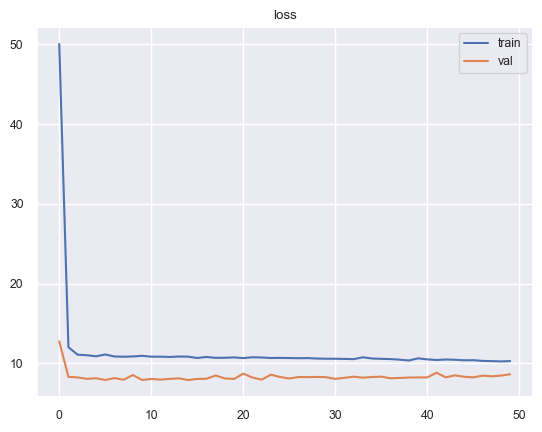

In [25]:
# epoch에 따른 loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label = 'train')
plt.plot(val_loss, label = 'val')
plt.title('loss')
plt.legend() # 우측 상단에 그래프 정보 띄워주는 거
plt.show()

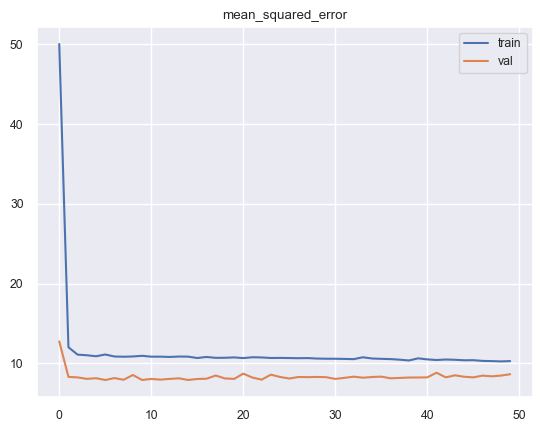

In [26]:
# Epoch에 따른 MSE
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
plt.plot(mse, label='train')
plt.plot(val_mse, label='val')
plt.title('mean_squared_error')
plt.legend()
plt.show()

## 2.1. 평가 및 문제사항

In [27]:
# evaluate the model - train
from sklearn.metrics import mean_squared_error

y_preds_train = model(X_train_seq)
print(f"MSE(train): {mean_squared_error(y_preds_train, y_train_seq)}")

MSE(train): 10.18701430836701


In [28]:
# evaluate the model - test

y_preds_test = model(X_test_seq)
print(f"MSE(test): {mean_squared_error(y_preds_test, y_test_seq)}")

MSE(test): 11.172693875017803


In [29]:
preds = model(X_train_seq)
for pred in preds:
    print(pred)

tf.Tensor([10.124732], shape=(1,), dtype=float32)
tf.Tensor([9.799198], shape=(1,), dtype=float32)
tf.Tensor([11.491607], shape=(1,), dtype=float32)
tf.Tensor([9.292115], shape=(1,), dtype=float32)
tf.Tensor([11.711627], shape=(1,), dtype=float32)
tf.Tensor([10.428225], shape=(1,), dtype=float32)
tf.Tensor([8.998152], shape=(1,), dtype=float32)
tf.Tensor([9.123788], shape=(1,), dtype=float32)
tf.Tensor([9.650031], shape=(1,), dtype=float32)
tf.Tensor([8.13074], shape=(1,), dtype=float32)
tf.Tensor([9.131557], shape=(1,), dtype=float32)
tf.Tensor([9.290669], shape=(1,), dtype=float32)
tf.Tensor([7.6523385], shape=(1,), dtype=float32)
tf.Tensor([10.156475], shape=(1,), dtype=float32)
tf.Tensor([11.099886], shape=(1,), dtype=float32)
tf.Tensor([8.658918], shape=(1,), dtype=float32)
tf.Tensor([10.492703], shape=(1,), dtype=float32)
tf.Tensor([9.942328], shape=(1,), dtype=float32)
tf.Tensor([10.584847], shape=(1,), dtype=float32)
tf.Tensor([10.846719], shape=(1,), dtype=float32)
tf.Tensor([

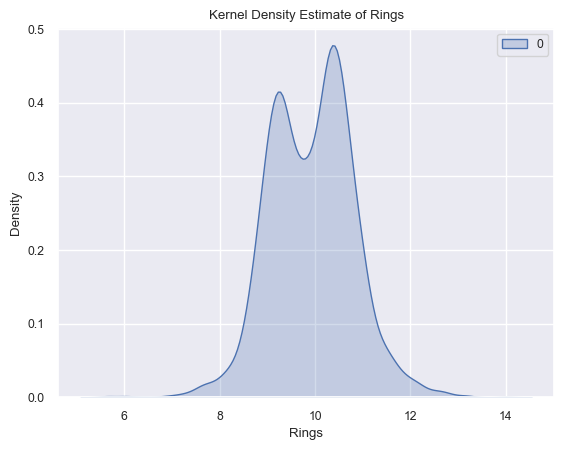

In [30]:
sns.kdeplot(preds, fill=True)
plt.title('Kernel Density Estimate of Rings')
plt.xlabel('Rings')
plt.ylabel('Density')
plt.show()

# 예측이 8 ~ 12에만 있음

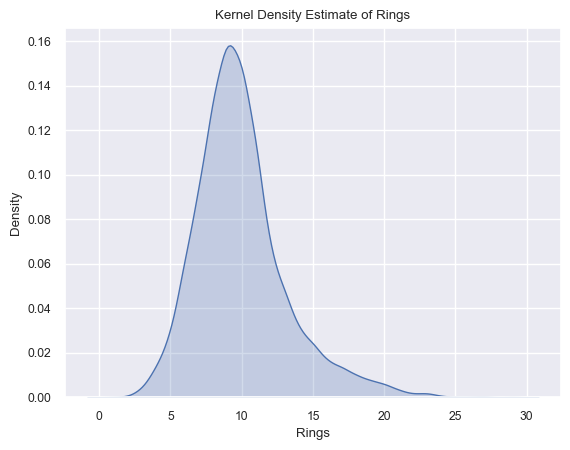

In [31]:
sns.kdeplot(df['Rings'], fill=True)
plt.title('Kernel Density Estimate of Rings')
plt.xlabel('Rings')
plt.ylabel('Density')
plt.show()

# sampling bias(imbalanced data)